In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-84299dd8-01cc-6cb2-3457-1ef28ce7af89)


In [ ]:
!pip install parsinorm
import parsinorm as p

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Part A

In [6]:
class CustomDataset(Dataset):
  def __init__(self, _type, sentences, labels, embed_dict, transform=None):
        self.transform = transform
        self.sentences = np.array(sentences)
        self.embed_dict = embed_dict
        self.labels = labels
        label_encoder = LabelEncoder()
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = label_encoder.fit_transform(self.labels)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        self.labels_onehot_encoded = {l: onehot_encoded[index] for index, l in enumerate(self.labels)}
      
        np.random.seed(seed=42)
        np.random.shuffle(self.sentences)
        if _type == 'Train':
          self.sentences = self.sentences[0:int(len(self.sentences) * 0.8)]
        elif _type == 'Test':
          self.sentences = self.sentences[int(len(self.sentences) * 0.8):int(len(self.sentences) * 0.9)]
        elif _type == 'Val':
          self.sentences = self.sentences[int(len(self.sentences) * 0.9):]

  def __len__(self):
        return len(self.sentences)
    
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        
        raw_tags = self.sentences[idx][1]
        tags = np.zeros(shape=(len(raw_tags), len(self.labels)))
        for index, tag in enumerate(raw_tags):
          try: 
            tags[index] = self.labels_onehot_encoded[tag]
          except KeyError:
            tags[index] = self.labels_onehot_encoded['unkwon']

        raw_sentence = self.sentences[idx][0]
        sentence_words = np.zeros(shape=(len(raw_sentence), ))
        for index, word in enumerate(raw_sentence):
          try: 
            sentence_words[index] = self.embed_dict[word]
          except KeyError:
            sentence_words[index] = self.embed_dict['<unk>']
            tags[index] = self.labels_onehot_encoded['unkwon']

                
        sentence_words = torch.from_numpy(sentence_words)
        tags = torch.from_numpy(tags)
        
        if self.transform:
            sentence_words = self.transform(sentence_words)
            tags = self.transform(tags)
            
        return sentence_words, tags
                

Part A: Preprocess

In [7]:
from parsinorm import Special_numbers
special_numbers = Special_numbers()

from parsinorm import General_normalization
general_normalization = General_normalization()

from parsinorm import Abbreviation
abbreviation = Abbreviation()

In [8]:
path = '/content/drive/MyDrive/HW3_Part2_Dataset/UPC-2016.txt'
with open(path) as f:   
  lines = f.readlines()

labels = ['ADJ','ADJ_CMPR','ADJ_INO','ADJ_SUP','ADJ_VOC','ADV','ADV_COMP','ADV_I','ADV_LOC','ADV_NEG',
          'ADV_TIME','CLITIC','CON','DELM','DET','FW','INT','N_PL','N_SING','NUM','N_VOC','P','PREV',
          'PRO','SYM','V_AUX','V_IMP','V_PA','V_PP','V_PRS', 'V_SUB', 'unkwon']
sentences = []      
words = []
tags = []
for line in lines:
  if line != '\n' and len(line.split("\t")) >= 2:
    this_line_word = line.split("\t")[0]
    if not(this_line_word.isnumeric()):
      this_line_word = general_normalization.semi_space_correction(sentence = this_line_word)
      this_line_word = general_normalization.arabic_correction(sentence = this_line_word)
      this_line_word = general_normalization.english_correction(sentence = this_line_word)
      this_line_word = general_normalization.remove_repeated_punctuation(sentence = this_line_word)
      
    words.append(this_line_word)
    tags.append(line.split("\t")[1][0:-1])
  if line == '\n':
    sentences.append([words, tags])
    words = []
    tags = []


Part B: Encoding

In [10]:
with open('/content/drive/MyDrive/HW3_Part2_Dataset/glove.6B.100d.txt') as embed:
  lines_embed = embed.readlines()

words = []
vectors = []
for item in lines_embed:
  words.append(item.split(" ")[0])
  vect = item.split(" ")[1:]
  vect = [float(x) for x in vect]
  vectors.append(vect)
glove = {w: vectors[i] for i, w in enumerate(words)}
glove_index = {w: i for i, w in enumerate(words)}

In [11]:
matrix_len = len(words)
emb_dim = 300
weights_matrix = np.zeros((matrix_len, emb_dim))

for i, word in enumerate(words): 
    weights_matrix[i] = glove[word]

weights_matrix = torch.from_numpy(weights_matrix)

In [12]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = len(weights_matrix), len(weights_matrix[0])
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim


In [ ]:
trainloader = torch.utils.data.DataLoader(CustomDataset('Train', sentences, labels, glove_index),
                                          batch_size=1, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(CustomDataset('Test', sentences, labels, glove_index),
                                         batch_size=1, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(CustomDataset('Val', sentences, labels, glove_index),
                                         batch_size=1, shuffle=True, num_workers=2)

Part C

In [25]:
class Rerccurent(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, weights_matrix,_type, D=1):
        super(Rerccurent, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self._type = _type
        self.D = D
        if D == 1:bidir = False 
        else: bidir = True

        if _type == "RNN":
          self.rerccurent = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidir)
        elif _type == "LSTM":
          self.rerccurent = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidir)
        elif  _type == "GRU":
          self.rerccurent = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=bidir)

        self.fc = nn.Linear(hidden_size * D, num_classes)

    def forward(self, x):
        h0 = torch.zeros((self.num_layers * self.D, x.size(0), self.hidden_size)).to(device)
        c0 = torch.zeros((self.num_layers * self.D, x.size(0), self.hidden_size)).to(device)
        x = self.embedding(x)
        if self._type == "RNN":
          out, _ = self.rerccurent(x, h0)
        elif self._type == "LSTM":
          out, _ = self.rerccurent(x, (h0, c0))
        elif  self._type == "GRU":
          out, _ = self.rerccurent(x, h0)
        
        out = self.fc(out)
        return out

In [26]:
model_rnn = Rerccurent(300, 128, 1, 32, weights_matrix, "RNN", D=1).to(device)
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_rnn, gamma=0.9)

In [27]:
def Train_Model(device, model, scheduler, criterion, optimizer, trainloader, valloader):
  train_acc = []
  train_loss = []
  train_f1_macro = []
  train_f1_micro = []

  val_acc = []
  val_loss = []
  val_f1_macro = []
  val_f1_micro = []

  for epoch in range(10):
      running_loss = 0.0
      running_acc = 0.0
      running_f1_macro = 0.0
      running_f1_micro = 0.0
      
      val_running_loss = 0.0
      val_running_acc = 0.0
      val_running_f1_macro = 0.0
      val_running_f1_micro = 0.0
      
      for i, data in enumerate(trainloader, 0):
          sentence_words, tags = data[0].to(torch.int), data[1].to(torch.float32)
          #print(sentence_words)
          sentence_words = sentence_words.to(device)
          tags = tags.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
        
          # forward + backward + optimize
          if sentence_words.size()[1] > 0:
            outputs = model(sentence_words)
            loss = criterion(outputs, tags)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            true = torch.argmax(tags, dim=2).cpu().numpy()[0]
            pred = torch.argmax(outputs, dim=2).cpu().numpy()[0]
            running_acc += accuracy_score(true, pred)
            running_f1_macro += f1_score(true, pred, average='macro')
            running_f1_micro += f1_score(true, pred, average='micro')

          ########################## Print Statistics ##########################
          d = 1000
          if i % d == d-1:
            print('[%d, %5d] loss Train: %.8f' % (epoch + 1, i + 1, running_loss / d))
            print('Train Accyracy : ', running_acc / d)
            print('Train f1_macro : ', running_f1_macro / d)
            print('Train f1_micro : ', running_f1_micro / d)
            train_loss.append(running_loss / d)
            train_acc.append(running_acc / d)
            train_f1_macro.append(running_f1_macro / d)
            train_f1_micro.append(running_f1_micro / d)
            running_loss = 0.0
            running_acc = 0.0
            running_f1_macro = 0.0
            running_f1_micro = 0.0
      
      scheduler.step()
      ################################## Val #################################
      with torch.no_grad():
        for j, data_val in enumerate(valloader, 0):
          sentence_words, tags = data_val[0].to(torch.float32), data_val[1].to(torch.float32)
          sentence_words = sentence_words.to(device)
          tags = tags.to(device)

          if sentence_words.size()[1] > 0:
            outputs = model(sentence_words)
            loss = criterion(outputs, tags)
            
            val_running_loss += loss.item()
            true = torch.argmax(tags, dim=2).cpu().numpy()[0]
            pred = torch.argmax(outputs, dim=2).cpu().numpy()[0]
            val_running_acc += accuracy_score(true, pred)
            val_running_f1_macro += f1_score(true, pred, average='macro')
            val_running_f1_micro += f1_score(true, pred, average='micro')

        val_loss.append(val_running_loss / len(valloader))
        val_acc.append(val_running_acc / len(valloader))
        val_f1_macro.append(val_running_f1_macro / len(valloader)) 
        val_f1_micro.append(val_running_f1_micro / len(valloader))

  return  train_acc, train_loss, train_f1_macro, train_f1_micro, val_acc, val_loss, val_f1_macro, val_f1_micro

In [ ]:
train_acc, train_loss, train_f1_macro, train_f1_micro, val_acc, val_loss, val_f1_macro, val_f1_micro = Train_Model(device,
    model_rnn, scheduler, criterion, optimizer_rnn, trainloader, valloader)

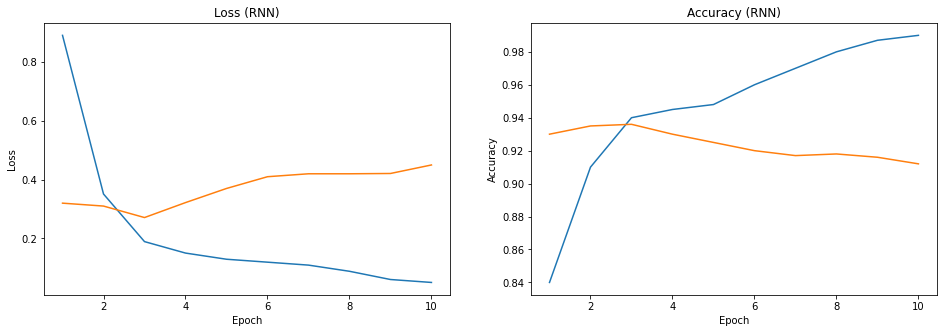

In [22]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 11), train_loss)
axarr[0].set_xlabel('Epoch')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Loss (RNN)")
axarr[0].plot(range(1, 11), val_loss)

axarr[1].plot(range(1, 11), train_acc)
axarr[1].set_xlabel('Epoch')
axarr[1].set_ylabel('Accuracy')
axarr[1].set_title("Accuracy (RNN)")
axarr[1].plot(range(1, 11), val_acc)


Part D

In [ ]:
model_lstm = Rerccurent(300, 128, 1, 32, "LSTM", D=1).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lstm, gamma=0.9)

In [ ]:
train_acc, train_loss, train_f1_macro, train_f1_micro, val_acc, val_loss, val_f1_macro, val_f1_micro = Train_Model(device,
    model_lstm, scheduler, criterion, optimizer_lstm, trainloader, valloader)

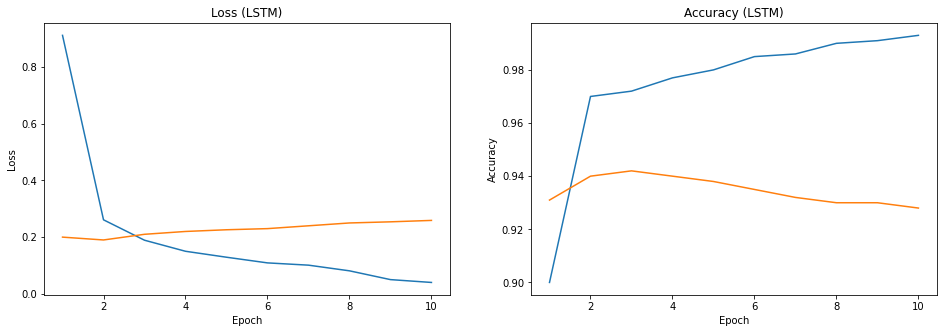

In [25]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 11), train_loss)
axarr[0].set_xlabel('Epoch')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Loss (LSTM)")
axarr[0].plot(range(1, 11), val_loss)

axarr[1].plot(range(1, 11), train_acc)
axarr[1].set_xlabel('Epoch')
axarr[1].set_ylabel('Accuracy')
axarr[1].set_title("Accuracy (LSTM)")
axarr[1].plot(range(1, 11), val_acc)


In [ ]:
model_gru = Rerccurent(300, 128, 1, 32, "GRU", D=1).to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_gru, gamma=0.9)

In [ ]:
train_acc, train_loss, train_f1_macro, train_f1_micro, val_acc, val_loss, val_f1_macro, val_f1_micro = Train_Model(device,
    model_gru, scheduler, criterion, optimizer_gru, trainloader, valloader)

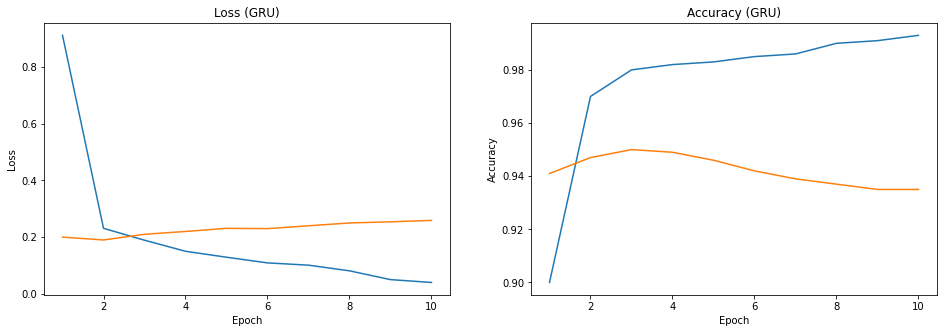

In [41]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 11), train_loss)
axarr[0].set_xlabel('Epoch')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Loss (GRU)")
axarr[0].plot(range(1, 11), val_loss)

axarr[1].plot(range(1, 11), train_acc)
axarr[1].set_xlabel('Epoch')
axarr[1].set_ylabel('Accuracy')
axarr[1].set_title("Accuracy (GRU)")
axarr[1].plot(range(1, 11), val_acc)


Part E

In [ ]:
model_gru = Rerccurent(300, 128, 1, 32, "GRU", D=2).to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_gru, gamma=0.9)

In [ ]:
train_acc, train_loss, train_f1_macro, train_f1_micro, val_acc, val_loss, val_f1_macro, val_f1_micro = Train_Model(
    model_gru, scheduler, criterion, optimizer_gru, trainloader, valloader)

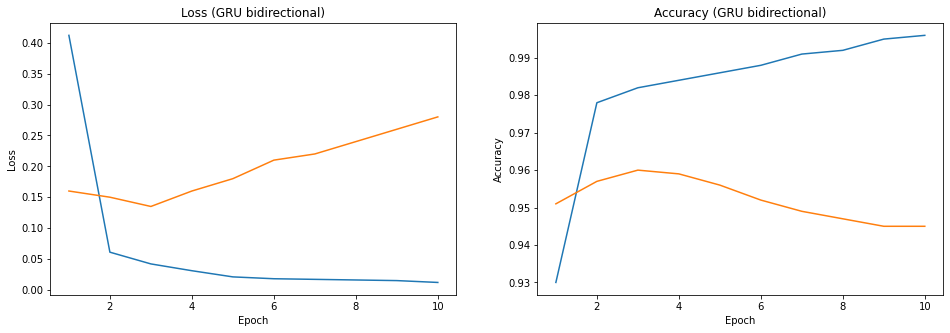

In [58]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 11), train_loss)
axarr[0].set_xlabel('Epoch')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Loss (GRU bidirectional)")
axarr[0].plot(range(1, 11), val_loss)

axarr[1].plot(range(1, 11), train_acc)
axarr[1].set_xlabel('Epoch')
axarr[1].set_ylabel('Accuracy')
axarr[1].set_title("Accuracy (GRU bidirectional)")
axarr[1].plot(range(1, 11), val_acc)
